## The Notebook is used for the Assignment: Bias in Data

The goal of the analysis is to understand bias in the article coverage for politicians across countries. 

Related Data Files
raw data files:

page_data.csv : raw wikipedia data
WPDS_2018_data.csv : raw country population data

Output files:

wp_wpds_politicians_by_country.csv : combined data (country population, ores data and wikipedia data)

In [3]:
import pandas as pd 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First I download the data from the two source files into a data frame. Then I read the data frame to see how the data is structured. 

In [4]:
Page_Data = pd.read_csv('page_data.csv', encoding='utf-8')

In [5]:
WPDS = pd.read_csv('WPDS_2018_data.csv', encoding='utf-8') ##after removing the geography related information in excel.

In [6]:
Page_Data.head()


,page,country,rev_id
0,Template:ZambiaProvincialMinisters,Zambia,235107991
1,Bir I of Kanem,Chad,355319463
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046
3,Template:Uganda-politician-stub,Uganda,391862070
4,Template:Namibia-politician-stub,Namibia,391862409


In [7]:
WPDS.head()

,Geography,Population mid-2018 (millions)
0,Algeria,42.7
1,Egypt,97
2,Libya,6.5
3,Morocco,35.2
4,Sudan,41.7


#### Processing of the Data:
I used excel to process the data. Here are the steps which I took
1. Removed all the page names which start with "Template:"
2. Copied the remaining and stored in a CSV files
3. Imported them back into the jupyter notebook as Clean_Page_Data
1. Filtered all the capital letterd geography data from WPDS data and stored in a seperate file.
2. Saved the remaining file as CSV

In [74]:
Clean_Page_Data = pd.read_csv('clean_page_data.csv', encoding='utf-8')

In [9]:
Clean_Page_Data.head()

,page,country,rev_id
0,Bir I of Kanem,Chad,355319463
1,Information Minister of the Palestinian Nation...,Palestinian Territory,393276188
2,Yos Por,Cambodia,393822005
3,Julius Gregr,Czech Republic,395521877
4,Edvard Gregr,Czech Republic,395526568


In the below code, we go to the Ores API to score the quality of the politician wikipedia pages. Most of this part of the code was taken from the wiki page provided for the course assignment. https://wiki.communitydata.science/Human_Centered_Data_Science_(Fall_2019)/Assignments#A2:_Bias_in_data


In [28]:
import requests
import json

headers = {'User-Agent' : 'https://github.com/your_github_RCRK', 'From' : 'ratna@uw.edu'}

def get_ores_data(revision_ids, headers):
    
    # Define the endpoint
    endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}'
    
    # Specify the parameters - smushing all the revision IDs together separated by | marks.
    # Yes, 'smush' is a technical term, trust me I'm a scientist.
    # What do you mean "but people trusting scientists regularly goes horribly wrong" who taught you tha- oh.  
    params = {'project' : 'enwiki',
              'model'   : 'wp10',
              'revids'  : '|'.join(str(x) for x in revision_ids)
              }
    api_call = requests.get(endpoint.format(**params))
    response = pd.read_json(json.dumps(api_call.json(), indent=4, sort_keys=True))
    for id in response['enwiki']['scores']:
        try:
            response_data.append([id, response['enwiki']['scores'][id]['wp10']['score']['prediction']])
        except:
            response_fail.append([id])
    
    #print(response)
    #return response
    ##return (response, indent=4, sort_keys=True)
    ##print(Predict)
    


In the below code the data in the Clean_page_data is split into 472 shunks so that every time only a 100 of them are fed to the API for scoring. The data is collected into two files. Response_data file for all the rev_id's where ores gave a prediction. When there were no predictions, it is captured in the response_fail file. There were 155 articles whcih ores was not able to provide any prediction.

In [30]:
response_data = []
response_fail = []
for i in np.array_split(np.asarray(Clean_Page_Data['rev_id']),472): 
    get_ores_data(i, headers)

In [34]:
print(len(response_data))
print(len(response_fail))

46546
155


Here the response_data is converted into a data frame and the data is pushed into a CSV

In [37]:
response_data = pd.DataFrame(data=response_data, columns=['rev_id','prediction'])
response_data.to_csv('response_data.csv')

In [38]:
response_data.head()

,rev_id,prediction
0,355319463,Stub
1,393276188,Stub
2,393822005,Stub
3,395521877,Stub
4,395526568,Stub


The response_data was taken into excel and then joined with the WPD data together to create the final file with the 5 columns. The population column values are in millions.

In [39]:
final_data = pd.read_csv('wp_wpds_politicians_by_country.csv', encoding='utf-8')

In [40]:
final_data.head()

,country,article_name,revision_id,article_quality,population
0,Chad,Bir I of Kanem,355319463,Stub,15.4
1,Cambodia,Yos Por,393822005,Stub,16.0
2,Canada,Robert Douglas Cook,401577829,Stub,37.2
3,Egypt,List of Grand Viziers of Egypt,442937236,Stub,97.0
4,Pakistan,Sehba Musharraf,448555418,Stub,200.6


#### Analysis: Top Countries by coverage. Coverage defines % of articles per person. Here I multiplied the population * million so that we get the population and then used this to generate the coverage. I did all of the data grouping and pivoting in excel and generated CSV files for each of the different analysis. Then saved those files into CSV to be loaded into jupyter

In [59]:
coverage = pd.read_csv('coverage.csv', encoding='utf-8')

In [60]:
coverage.head()

,Country,Population(MM),articles,CoveragePerPerson
0,Afghanistan,36.50,320,0.01%
1,Albania,2.90,457,0.16%
2,Algeria,42.70,116,0.00%
3,Andorra,0.08,34,0.43%
4,Angola,30.40,106,0.00%


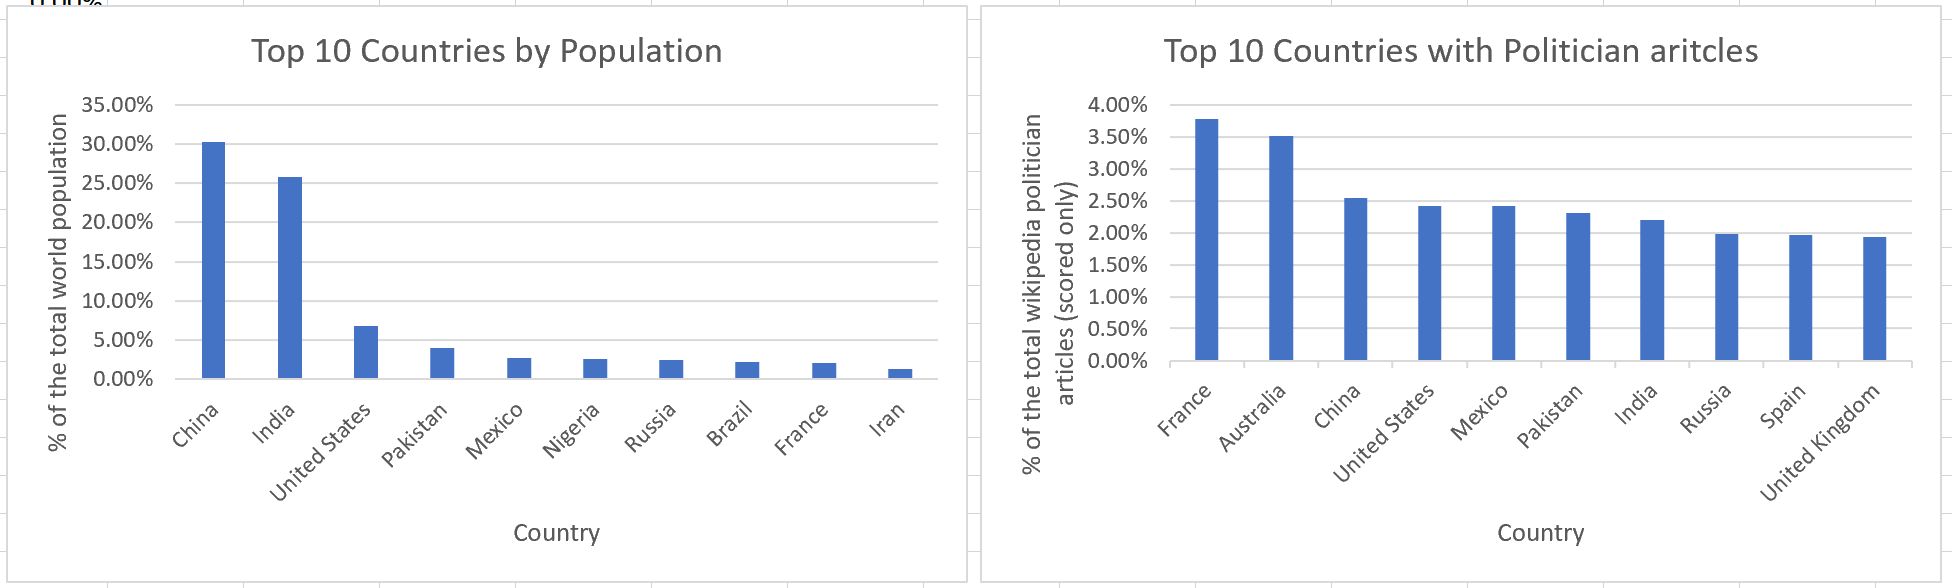

In [78]:
from PIL import Image
display(Image.open("Capture.png"))

## Top 10 countreis sorted highest rank in coverage

In [62]:
coverage.sort_values(by = 'CoveragePerPerson',ascending = False)[0:10]

,Country,Population(MM),articles,CoveragePerPerson
166,Tuvalu,0.01,54,5.40%
115,Nauru,0.01,52,5.20%
135,San Marino,0.03,81,2.70%
108,Monaco,0.04,40,1.00%
93,Liechtenstein,0.04,28,0.70%
161,Tonga,0.10,63,0.63%
103,Marshall Islands,0.06,37,0.62%
68,Iceland,0.40,201,0.50%
3,Andorra,0.08,34,0.43%
61,Grenada,0.10,36,0.36%


It is interesting to note that Tuvalu has 5.4% coverage for political articles per person. 

## Bottom 10 countreis sorted lowest rank in coverage

In [63]:
coverage.sort_values(by = 'CoveragePerPerson',ascending = True)[0:10]

,Country,Population(MM),articles,CoveragePerPerson
69,India,1371.3,980,0.00%
47,Egypt,97.0,235,0.00%
23,Brazil,209.4,547,0.00%
25,Burkina Faso,20.3,95,0.00%
138,Senegal,16.3,42,0.00%
28,Cameroon,25.6,103,0.00%
137,Saudi Arabia,33.4,118,0.00%
178,Zambia,17.7,25,0.00%
151,Sudan,41.7,95,0.00%
128,Philippines,107.0,504,0.00%


### Top 10 countries by relative quality. Relative quality here refers to the articles which were predicted to be FA("Featured Articles") or GA("Good Articles") clasess divided by the total articles.

In [64]:
relativequality = pd.read_csv('relativequality.csv', encoding='utf-8')

In [65]:
relativequality.head()

,country,Restofthelabels,GAandFA,total,relative quality
0,Afghanistan,308,12.0,320,3.75%
1,Albania,454,3.0,457,0.66%
2,Algeria,114,2.0,116,1.72%
3,Andorra,34,NaN,34,0.00%
4,Angola,106,NaN,106,0.00%


In [66]:
relativequality.sort_values(by = 'relative quality',ascending = False)[0:10]

,country,Restofthelabels,GAandFA,total,relative quality
166,Tuvalu,49,5.0,54,9.26%
19,Bhutan,30,3.0,33,9.09%
44,Dominica,11,1.0,12,8.33%
155,Syria,118,10.0,128,7.81%
18,Benin,84,7.0,91,7.69%
62,Guatemala,77,6.0,83,7.23%
173,Uzbekistan,26,2.0,28,7.14%
171,United States,1001,77.0,1078,7.14%
176,Vietnam,175,12.0,187,6.42%
170,United Kingdom,803,55.0,858,6.41%


## Bottom 10 countries by Relative Quality

In [67]:
relativequality.sort_values(by = 'relative quality',ascending = True)[0:10]

,country,Restofthelabels,GAandFA,total,relative quality
81,Kiribati,30,NaN,30,0.00%
30,Cape Verde,37,NaN,37,0.00%
36,Comoros,51,NaN,51,0.00%
38,Costa Rica,147,NaN,147,0.00%
115,Nauru,52,NaN,52,0.00%
43,Djibouti,37,NaN,37,0.00%
114,Namibia,162,NaN,162,0.00%
112,Mozambique,58,NaN,58,0.00%
49,Eritrea,16,NaN,16,0.00%
50,Estonia,149,NaN,149,0.00%


## Geographic Regions by coverage. This uses the geographic locations which were provided and their population. 

In [68]:
geocoverage = pd.read_csv('geocoverage.csv', encoding='utf-8')

In [69]:
geocoverage.head()

,Geography,articles,population(mm),Coverage per person
0,AFRICA,6851,"1,284",0.00%
1,ASIA,11531,"4,536",0.00%
2,EUROPE,15864,746,0.00%
3,LATIN AMERICA AND THE CARIBBEAN,5169,649,0.00%
4,NORTHERN AMERICA,1921,365,0.00%


In [70]:
geocoverage.sort_values(by = 'Coverage per person',ascending = False)

,Geography,articles,population(mm),Coverage per person
5,OCEANIA,3128,41,0.01%
0,AFRICA,6851,"1,284",0.00%
1,ASIA,11531,"4,536",0.00%
2,EUROPE,15864,746,0.00%
3,LATIN AMERICA AND THE CARIBBEAN,5169,649,0.00%
4,NORTHERN AMERICA,1921,365,0.00%


## Geographic region by relative quality.

In [76]:
georelativequality = pd.read_csv('georelativequality.csv', encoding='utf-8') #reading geographic regions relative quality

In [77]:
georelativequality.head() #visually making sure that the data is accurate

,Geography,Restofthelabels,FAandGA,Total,Relative Quality
0,AFRICA,6726,125,6851,1.82%
1,ASIA,11221,310,11531,2.69%
2,EUROPE,15542,322,15864,2.03%
3,LATIN AMERICA AND THE CARIBBEAN,5100,69,5169,1.33%
4,NORTHERN AMERICA,1822,99,1921,5.15%


In [73]:
georelativequality.sort_values(by = 'Relative Quality',ascending = False) # sorted gregraphic locations

,Geography,Restofthelabels,FAandGA,Total,Relative Quality
4,NORTHERN AMERICA,1822,99,1921,5.15%
1,ASIA,11221,310,11531,2.69%
5,OCEANIA,3062,66,3128,2.11%
2,EUROPE,15542,322,15864,2.03%
0,AFRICA,6726,125,6851,1.82%
3,LATIN AMERICA AND THE CARIBBEAN,5100,69,5169,1.33%


### Summary:
Processing the Wikipedia articles for politicians and getting the ores scores for these definitely was a learning experience. Getting the scoring to work was more work than I anticpipated. There are are a few observation on the raw data itself. We only had 47K articles, represented for 180 countries. The intersting fact which I observed is that the country with the most population is the not the one which has the highest politician articles in wikipedia. France is #9 with respect to population rank while it ranked #1 with respect to politician articles. The highest number of articles per person are in smaller countries, while the countries with the most population have per capita lesser number of politician articles. If we consider Good and Featured articles, their share of the total articles per country is very low. The highest share of good and featured articles is only 9% which would mean that the the overall quality of the politician articles is not that great. 

Three Questions:

What (potential) sources of bias did you discover in the course of your data processing and analysis?
The data is not clean. The descriptions provided in the assignment document were very helpful else it would have been hard to clean the data. Bias in the data it feels like exisits and below are some of them:
1. Bias based on the language? Are there more information because of English language for countries which speak english. France is an exception
2. Very little coverage even in large countries which does not give enough sample sizes to reflect about a countries politicians.
2. Bias in the content which is posted? There is various levels of quality of the content so it is not consistent and bias in what is written
3. Bias based on who wrote the content? It is not clear if the people who wrote the content are writing it based on an unbiased view or if there is bias based on their political inclination. Their age, education, was it written by a single person per country? 
4. Bias in the content for countries who have internet connection? Is it possible that content for politicians is only present for countries which are internet connected broadly.
5. Time Bias, we dont have clarity if the content is written to describe what happened or history or more on today's events. 
6. Even within a country we do not know if it is covering all the states and geographic locations at the same rate vs focussing on a specific region.

What might your results suggest about (English) Wikipedia as a data source?
Based on the relative quality of the content I don't feel comfortable using this data for making any broad statements about politicians and their country. It does not reflect that this is an unbiased data set for broader analysis.

Can you think of a realistic data science research situation where using these data (to train a model, perform a hypothesis-driven research, or make business decisions) might still be appropriate and useful, despite its inherent limitations and biases?

The popluation data can definitely be used in any modeling information. One scenario I can think of is if we have a hypothesis that the wikipedia content for other group of content like entertainment or education has a similar accuracy as politician articles. We can use as a benchmark to compare against other slices. One other thought is may be you can make a hypothesis that the politicians who are in wikipedia for a country and have high good and featured articles are popular in their country. We can then use the article prediction and validate it. Though I have not personally validated the data so not sure.
